In [1]:
# Import libraries
# type: ignore
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

# plot style setup
colors = ['#0000ff', '#ffa500', '#ed3005', '#a3aaae']

In [2]:
# Read data
data = pd.read_csv("../Data/raw/churn-data.csv", usecols=range(1, 14))

# Check first few rows
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Shape of the data.
data.shape

(10000, 13)

In [4]:
# Metadata information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


- *The dataset has 10000 rows and 12 columns*
- *There are no missing values as each column has 10000 rows of non-null vlaues which is same as total rows.*
- *The data types of columns looks good.*

In [5]:
# Remove duplicates
print("Number of unique customers in dataset::", data.CustomerId.nunique())
print("Number of duplicates in data::", data.duplicated().sum().item())

Number of unique customers in dataset:: 10000
Number of duplicates in data:: 0


In [6]:
# Rename column names
data.columns = data.columns.map(lambda x: x.lower())
col_names = {
    'customerid': 'customer_id',
    'creditscore': 'credit_score',
    'numofproducts': 'num_of_products',
    'hascrcard': 'has_cr_card',
    'isactivemember': 'is_active_member',
    'estimatedsalary': 'salary',
    'exited': 'churn'
}

data.rename(columns = col_names, inplace=True)

### Split dataset into training and test datasets

In [7]:
# Split the data in training, validation and test datasets in ratio of 60:20:20
fullset, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['churn'])
train_data, val_data = train_test_split(fullset, test_size=0.25, random_state=42, stratify=fullset['churn'])

print(f'Shape of Datasets:\nTrain Data ==> {train_data.shape}\nValidation Data ==> {val_data.shape}\nTest Data ==> {test_data.shape}')

Shape of Datasets:
Train Data ==> (6000, 13)
Validation Data ==> (2000, 13)
Test Data ==> (2000, 13)


In [8]:
# Separate numerical and categorical features
numerical_df = train_data.select_dtypes(include='number')
categorical_df = train_data.select_dtypes(exclude='number')

In [9]:
# Drop the customer-id & surname column
numerical_df.drop(['customer_id'], axis=1, inplace=True)
categorical_df.drop(['surname'], axis=1, inplace=True)

### Exploratory Data Analysis

In [10]:
# Summary statistics
numerical_df.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,salary,churn
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,651.102500,38.959667,5.027833,77261.098155,1.533833,0.709667,0.515500,99452.181700,0.203833
std,96.645467,10.482144,2.907943,62284.911851,0.584733,0.453954,0.499801,57283.092853,0.402880
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.000000
50%,652.000000,37.000000,5.000000,97757.240000,1.000000,1.000000,1.000000,99107.435000,0.000000
75%,717.000000,44.000000,8.000000,128293.950000,2.000000,1.000000,1.000000,147891.152500,0.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000


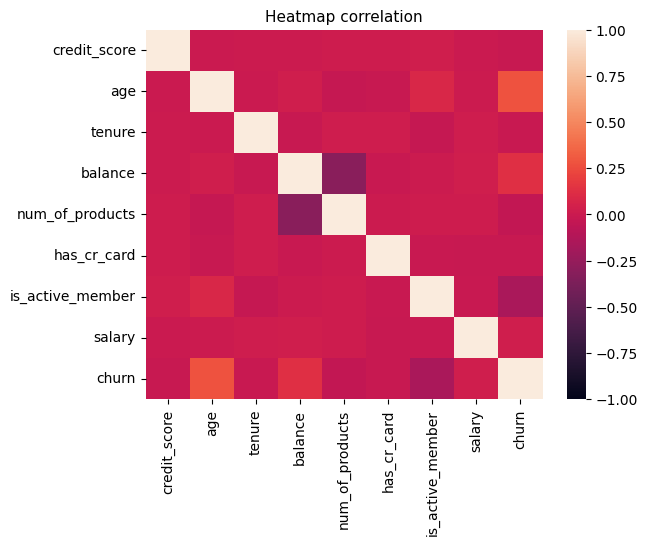

In [11]:
# Correlation between numerical features and target variable
num_corr = numerical_df.corr()

sns.heatmap(num_corr, vmin=-1, vmax=1)
plt.title('Heatmap correlation', size=11);

- *The age, balance and is_active_member shows some correlation with target variable.*
- *There is no strong correlation between the numerical features and target variables.*

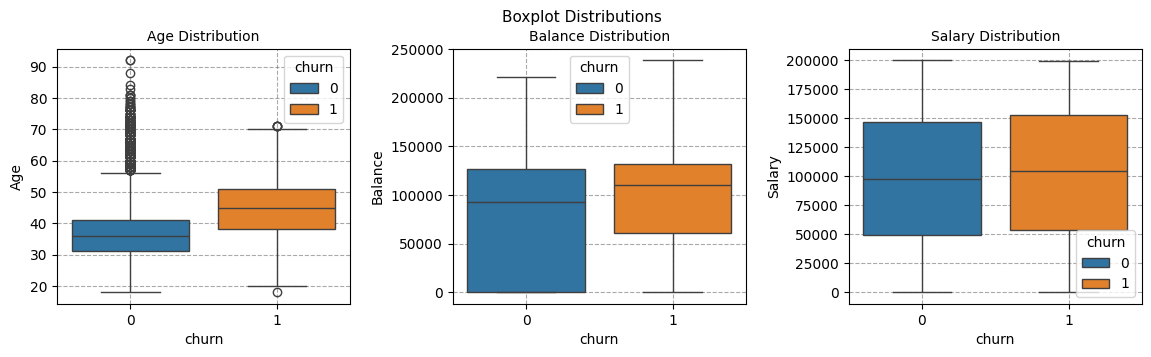

In [12]:
# Numerical features distribution 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle("Boxplot Distributions", va='top', size=11)
fig.subplots_adjust(wspace=0.35, top=0.85, bottom=0)

# Boxplot
sns.boxplot(numerical_df, x='churn', y='age', hue='churn', ax=ax1)
sns.boxplot(numerical_df, x='churn', y='balance', hue='churn', ax=ax2)
sns.boxplot(numerical_df, x='churn', y='salary', hue='churn', ax=ax3)


# Add labels
ax1.set_title('Age Distribution', size=10)
ax2.set_title('Balance Distribution', size=10)
ax3.set_title('Salary Distribution', size=10)

ax1.set_ylabel("Age")
ax2.set_ylabel("Balance")
ax3.set_ylabel("Salary")

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)
ax3.grid(ls='--', color='#555', alpha=0.5);

- Age:
    - *From median, we can see that larger portion of the population is younger.*
    - *The box represents the middle 50% of the data are concentrated in lower ranges with few maximum ages for data with no customer churn*

- Balance:
    - *Distribution of balance shows highly right skewed distribution, wide IQR(box) indicates the variability in balances. Q1 equals to zero indicates 25th percentile of data with zero or minimum balance.*

- Salary:
    - *Distribution of salary seems to be a uniform distribution for both groups, large box represent wide range of salaries.*

In [13]:
# Balance
zero_balance_percent = round(numerical_df[train_data['balance'] == 0].shape[0] * 100 / numerical_df.shape[0], 2)
zero_balance_percent

35.52

- *36% of data has customers with zero balance.*

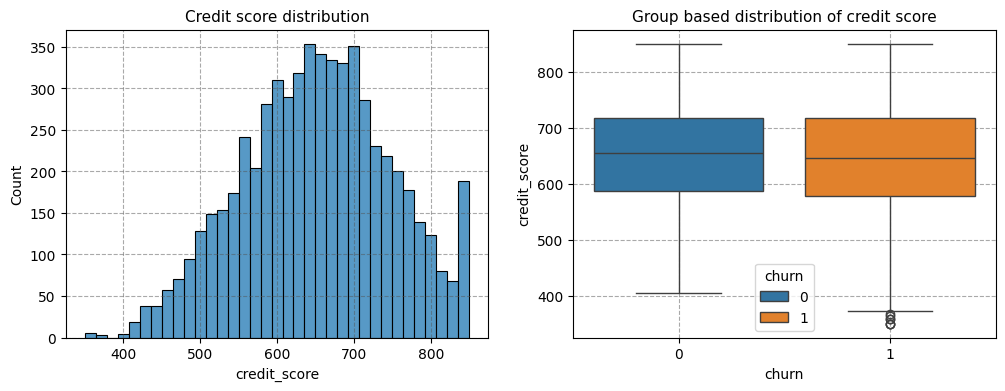

In [14]:
# Credit score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(numerical_df, x='credit_score', ax=ax1)
sns.boxplot(numerical_df, x='churn', y='credit_score', hue='churn', ax=ax2)

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5)

ax1.set_title('Credit score distribution', size=11)
ax2.set_title('Group based distribution of credit score', size=11);

- *Histplot shows, left skewed distribution in credit score indicating very low credit scores.*
- *Boxplot shows the normal distribution for both groups with some outliers in churn data suggesting customers with lower credit score tends to churn.*

In [15]:
# Tenure - Number of months of association between customer and bank.
print('Unique values in tenure ==> ', sorted(numerical_df.tenure.unique().tolist()))

Unique values in tenure ==>  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


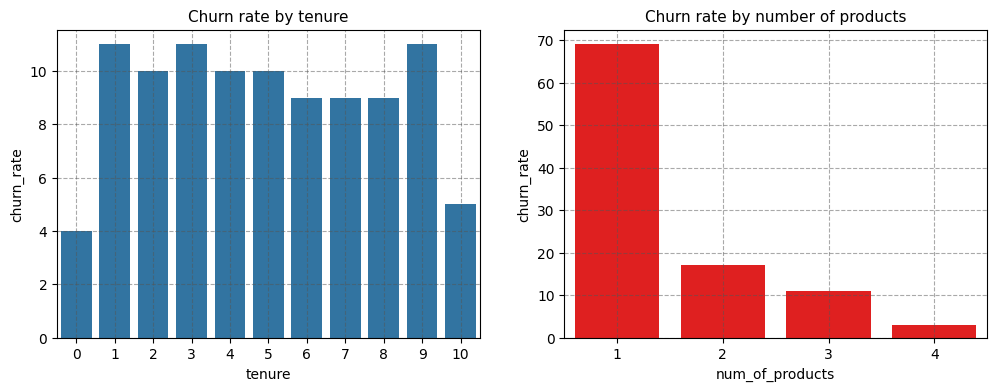

In [16]:
# Data preparation - Compute the churn rate by tenure 
a = numerical_df[numerical_df.churn == 1].groupby(['tenure']).size()
b = numerical_df[numerical_df.churn == 1].groupby(['num_of_products']).size()

tenure_churn_rate = (round((a * 100) / a.sum())).reset_index()
tenure_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

products_num_churn_rate = (round((b * 100) / b.sum())).reset_index()
products_num_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(tenure_churn_rate, x='tenure', y='churn_rate', ax=ax1)
sns.barplot(products_num_churn_rate, x='num_of_products', y='churn_rate', ax=ax2, color='red')

ax1.set_title("Churn rate by tenure", size=11)
ax2.set_title("Churn rate by number of products", size=11)

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5);

- *As we expected, rate of churn for new and old customers is comparitively low.*
- *Customer with single products shows appx. 70% of churn rate while customers with 4 products shows less than 5% churn rate.*

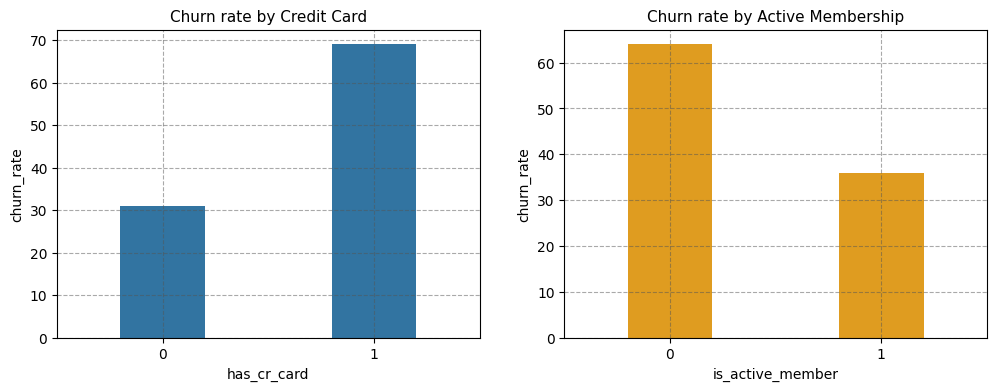

In [17]:
# Data preparation - Compute the churn rate by Credit card and active member.
a = numerical_df[numerical_df.churn == 1].groupby(['has_cr_card']).size()
b = numerical_df[numerical_df.churn == 1].groupby(['is_active_member']).size()

cc_churn_rate = (round((a * 100) / a.sum())).reset_index()
cc_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

active_mem_churn_rate = (round((b * 100) / b.sum())).reset_index()
active_mem_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(cc_churn_rate, x='has_cr_card', y='churn_rate', width=0.4, ax=ax1)
sns.barplot(active_mem_churn_rate, x='is_active_member', y='churn_rate', width=0.4, ax=ax2, color='orange')

ax1.set_title("Churn rate by Credit Card", size=11)
ax2.set_title("Churn rate by Active Membership", size=11)

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5);

- *Customers with credit cards, Inactive members shows high churn rate.*
- *So, 62% of customers who churned are in-active member, while ~38% of churned are from active members*.

In [18]:
# Print the unique values in categorical columns.
for col in categorical_df.columns:
    print(f"{col.capitalize()} ==>", sorted(categorical_df[col].unique().tolist()))

Geography ==> ['France', 'Germany', 'Spain']
Gender ==> ['Female', 'Male']


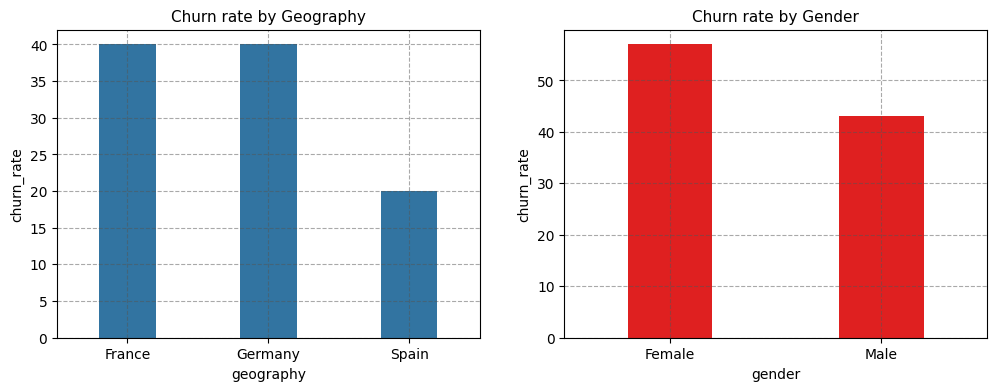

In [19]:
# Churn rate by Geography and Gender.
a = categorical_df[train_data.churn == 1].groupby(['geography']).size()
b = categorical_df[train_data.churn == 1].groupby(['gender']).size()

geo_churn_rate = (round((a * 100) / a.sum())).reset_index()
geo_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

gen_churn_rate = (round((b * 100) / b.sum())).reset_index()
gen_churn_rate.rename(columns={0: 'churn_rate'}, inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(geo_churn_rate, x='geography', y='churn_rate', width=0.4, ax=ax1)
sns.barplot(gen_churn_rate, x='gender', y='churn_rate', width=0.4, ax=ax2, color='red')

ax1.set_title("Churn rate by Geography", size=11)
ax2.set_title("Churn rate by Gender", size=11)

ax1.grid(ls='--', color='#555', alpha=0.5)
ax2.grid(ls='--', color='#555', alpha=0.5);

- *The bar plot compares the customer churn rate by location and gender of the customers.*
- *France and Germany shows the highest and equal churn rate.*
- *While distribution of gender churn rates shows highest rate of churn for female customers.*

In [20]:
# Calcuate the dependency between the categorical variable and target variable 'churn'.

def cal_corr(col_value):
    """
    Null Hypothesis (H0): Given categorical column and churn attributes are not independent.
    Alternative Hypothesis (H1): Given column and churn attributes are independent.
    """
    table = pd.crosstab(col_value, train_data['churn'])
    chi2, p_value, dof, expected  = chi2_contingency(observed=table, correction=False)
    
    alpha = 0.05  # Level of significance
    if p_value < alpha:
        result = "Yes"
    else:
        result = "No"
    return col, chi2, round(p_value, 3), dof, result

In [21]:
# Create a new categorical column lists.
cat_columns = ['geography', 'gender', 'tenure', 'num_of_products', 'has_cr_card', 'is_active_member']

corr_result = []
for col in cat_columns:
    corr_result.append(cal_corr(train_data[col]))

pd.DataFrame(corr_result, columns=['column', 'chi2-value', 'p-value', 'dof', 'is_dependent'])

,column,chi2-value,p-value,dof,is_dependent
0,geography,181.976897,0.000,2,Yes
1,gender,78.623924,0.000,1,Yes
2,tenure,7.205075,0.706,10,No
3,num_of_products,950.939361,0.000,3,Yes
4,has_cr_card,2.619002,0.106,1,No
5,is_active_member,152.304336,0.000,1,Yes


- *Geography, Gender, Number of products and Activity of member shows correlation with Churn.*

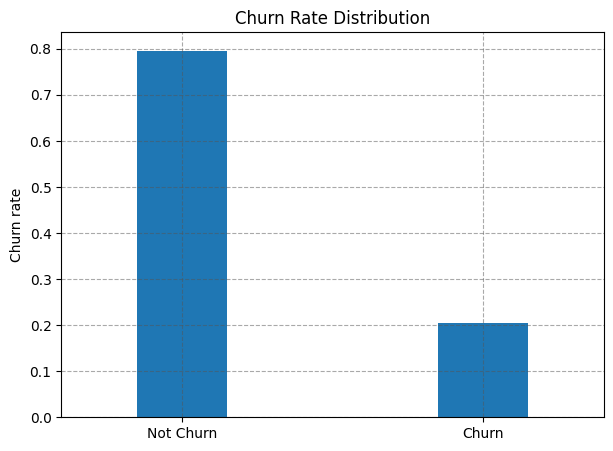

In [22]:
# Target distribution
train_data['churn'].value_counts(normalize=True).plot(kind='bar', 
                                                      figsize=(7, 5), 
                                                      width=0.3,
                                                      title='Churn Rate Distribution', 
                                                      xlabel='', ylabel='Churn rate')
plt.xticks(rotation=0, ticks=[0, 1], labels=['Not Churn', 'Churn'])
plt.grid(ls='--', c="#555", alpha=0.5);

- *The above bar plot shows the imbalance class distribution as number of one class label is significantly smaller than other.*

In [23]:
# Save data
train_data.to_csv('../Data/raw/train-data.csv', index=False)
val_data.to_csv('../Data/raw/validation-data.csv', index=False)
test_data.to_csv('../Data/raw/test-data.csv', index=False)